# Codice per generare ellissoidi di confidenza

In [50]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import norm

np.random.seed(42)

mean = [2, 3, 1]  # Media della distribuzione
covariance_matrix = np.array([[1, 0.5, 0.3], [0.5, 2, 0.2], [0.3, 0.2, 1]])  # Matrice di covarianza
num_points = 1000
points = np.random.multivariate_normal(mean, covariance_matrix, num_points)

# Calcolo della media e della covarianza dei punti generati
sample_mean = np.mean(points, axis=0)
sample_covariance = np.cov(points, rowvar=False)

# Calcolo degli autovalori e autovettori della covarianza
eigenvalues, eigenvectors = np.linalg.eig(sample_covariance)

# Calcolo dei quantili della distribuzione normale univariata
confidence_level = 0.95
quantile = norm.ppf((1 + confidence_level) / 2)

# Calcolo della dimensione dell'ellissoide basata sui quantili
scale_factors = np.sqrt(eigenvalues) * quantile

# Creazione di un ellissoide basato su autovalori ed autovettori
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = scale_factors[0] * np.outer(np.cos(u), np.sin(v))
y = scale_factors[1] * np.outer(np.sin(u), np.sin(v))
z = scale_factors[2] * np.outer(np.ones(np.size(u)), np.cos(v))

# Trasformazione dell'ellissoide in base ai parametri della covarianza
ellipsoid = np.dot(np.dot(eigenvectors, np.diag(scale_factors)), np.array([x.flatten(), y.flatten(), z.flatten()])) + sample_mean.reshape(-1, 1)

# Creazione di un oggetto Traces per la media e l'ellissoide
mean_trace = go.Scatter3d(x=[sample_mean[0]], y=[sample_mean[1]], z=[sample_mean[2]], mode='markers', marker=dict(size=10, color='red'), name='Sample Mean')
ellipsoid_trace = go.Surface(x=ellipsoid[0, :].reshape(100, 100), y=ellipsoid[1, :].reshape(100, 100), z=ellipsoid[2, :].reshape(100, 100),
                             opacity=0.3, colorscale='blues', name=f'Ellipsoid ({confidence_level} confidence)')

# Creazione della figura e aggiunta dei Traces
fig = go.Figure(data=[mean_trace, ellipsoid_trace])

# Configurazione dell'aspetto della figura
fig.update_layout(scene=dict(aspectmode="data", xaxis=dict(title='X'), yaxis=dict(title='Y'), zaxis=dict(title='Z')))
fig.update_layout(scene=dict(camera=dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=2, y=2, z=2))))

# Mostra la figura
fig.show()

# AML Final Project

In [ ]:
!rm -r ./*
!git clone https://github.com/Mamiglia/BNN_Human_motion
!mv BNN_Human_motion/* .

In [ ]:
!pip install bayesian-torch lightning

In [3]:
from funcs.dataloader import load_dataset
from funcs.pos_embed_p import Pos_Embed
from funcs.loss import *
from funcs.utils import h36motion3d as datasets
from funcs.utils.data_utils import *

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device, '- Type:', torch.cuda.get_device_name(0))

Using device: cuda - Type: Tesla T4


In [6]:
dataset, vald_dataset = load_dataset()

Loading Train Dataset...
Loading Validation Dataset...
>>> Training dataset length: 180077
>>> Validation dataset length: 28110


# Costum Model from HW3
- Encoder: Transfomer + CNN
- Decoder: LSTM

## Definition

### Encoder

In [ ]:
class Attention(nn.Module):
    # CLASSICAL ATTENTION MECHANISM
    # IT'S THE SAME OF THE TEORICAL PART

    def __init__(self, attn_dropout):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)
    def forward(self, query, key, value, mask=None):
        attn = torch.matmul(query, key.transpose(-2, -1))
        d_k = query.size(-1)
        attn = attn / (d_k ** 0.5)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(F.softmax(attn,-1))
        output = torch.matmul(attn, value)
        return output, attn

In [ ]:
class MultiHeadAttention(nn.Module):
    # ALSO THE MULTIHEAD ATTENTION MECHANISM IS THE SAME OF TEORICAL PART

    def __init__(self, num_heads, d_model, dropout):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        #  We assume d_v always equals d_k
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.query_ff = nn.Linear(d_model, d_model)
        self.key_ff = nn.Linear(d_model, d_model)
        self.value_ff = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.attention = Attention(attn_dropout=dropout)
    def forward(self, query, key, value, mask=None, return_attention=False):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query = self.query_ff(query).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.key_ff(key).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_ff(value).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        x, self.attn = self.attention(query, key, value, mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)
        if return_attention:
            return self.attn_ff(x), self.attn
        return x

In [ ]:
class EncoderBlock(nn.Module):
    # THE ENCODER BLOCK IS A TIPICAL TRANSFORMER ENCODER,
    # BUT WE HAVE ADDED A CONVOLUTIONAL LAYER AT THE END:
    # self.conv IS USED TO SHRINK THE INFORMATION ALONG THE ENCODER BLOCKS
    # THIS IS A METHOD TO DISTILL INFORMATION SHOULD BE PASSED TO THE DECODER
    # AND MOREOVER TO SAVE A LOT OF TIME

    def __init__(self,num_heads,d_model,time_in,time_out,num_joints,dropout):
        super().__init__()

        self.num_joints = num_joints
        self.d_model = d_model

        self.self_attn = MultiHeadAttention(num_heads, d_model, dropout)

        # LAYERNORM LAYERS AND DROPOUT
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        # MLP
        self.lin_net = nn.Sequential(
            nn.Linear(d_model,2*d_model),
            nn.ReLU(),
            nn.Linear(2*d_model,d_model),
            nn.ReLU()
        )

        # A CNN SHRINKS THE FRAMES FROM time_it TO time_out
        # AND THE d_model IS HALVED AFTER EACH BLOCK
        self.conv = nn.Conv1d(time_in,time_out,3,padding=1)

    def forward(self, xs, mask=None):
        x = xs
        att = self.self_attn(x, x, x, mask)
        x = self.relu(x + att)
        x = self.norm1(x)

        lin_output = self.lin_net(x)
        x = self.relu(x + self.dropout(lin_output))

        # WE ADD A RESIDUAL CONNECTION ALSO HERE
        # IT REDUCES A BIT THE VANISH GRADIENT
        x = self.norm2(x + xs)

        # SHRINK
        x = self.conv(x)

        return x

### Decoder

In [ ]:
class Decoder(nn.Module):
    # THE DECODER BLOCK IS A SIMPLE LSTM,
    # WHICH TAKES THE DISTILLED INFORMATION FROM THE
    # ENCODER AS HIDDEN STATE AND AUTOREGRESSIVLY
    # FORSEES THE NEXT FRAMES
    def __init__(self, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        # LSTM
        self.lstm = nn.LSTM(66, hidden_dim, num_layers=num_layers)
        # LINEAR self.out TO RETURN THE ORIGINAL DIMENSIONS
        self.out = nn.Linear(hidden_dim, 66)

    def forward(self, hidden, num_steps):
        # CELL STATE IS INITIALIZED TO ZEROS
        cell = nn.Parameter(torch.zeros(*hidden.shape)).to(device)
        batch_size = hidden.size(1)
        # THE <START> IS INITIALIZED TO ONES
        input = torch.ones((batch_size,66), dtype=torch.float).unsqueeze(0).to(device)
        outputs = torch.zeros((num_steps,batch_size,66), dtype=torch.float).to(device)

        for t in range(num_steps):
            # FORCAST
            decoder_output, (_,_) = self.lstm(input, (hidden,cell))
            # SET TO THE ORIGINAL DIMENSIONS
            decoder_output = self.out(decoder_output[-1])
            outputs[t] = decoder_output
            # STACK TO THE INPUT
            input = torch.cat((input,decoder_output.unsqueeze(0)),0)
        return outputs

### Model

In [ ]:
def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')

In [ ]:
def fc_init(fc):
    nn.init.kaiming_normal_(fc.weight, nonlinearity='relu')

In [ ]:
def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

In [ ]:
class Model(nn.Module):
    # THIS IS THE FINAL MODEL IN WHICH WE MERGED THE ENCODER AND DECODER PARTS
    def __init__(self, num_channels, num_frames_out,
                 old_frames, num_joints, num_heads, drop,
                 d_model = 512, config=None):
        super().__init__()

        # CONFIGURATION FOR THE ENCODER BLOCKS
        if config==None:
            self.config = [[d_model,10,8],[d_model,8,6],[d_model,6,4],[d_model,4,2],[d_model,2,1]]

        self.num_channels = num_channels
        self.num_frames_out = num_frames_out
        self.num_heads = num_heads
        self.num_joints = num_joints
        self.old_frames = old_frames
        self.d_model = d_model

        # LINEAR BLOCK TO PASS FROM INITIAL DIMENSION 66 TO d_model
        self.lin = nn.Sequential(nn.Linear(self.num_channels*self.num_joints,d_model),nn.BatchNorm1d(self.old_frames))
        self.norm = nn.BatchNorm2d(self.num_channels)

        # ENCODER
        self.blocks = nn.ModuleList()
        # d_ : d_model of the block;
        # in_ : number of frames of the sequences at the begin;
        # out_ : number of frames of the sequences at the end
        for index, (d_,in_,out_) in enumerate(self.config):
            self.blocks.append(EncoderBlock(num_heads=self.num_heads,
                                            d_model=d_, time_in=in_, time_out=out_,
                                            num_joints=self.num_joints,dropout=drop))

        # SINUSOIDAL POSITIONAL EMBEDDINGS
        self.pos = Pos_Embed(self.num_channels,self.old_frames,self.num_joints)
        # DECODER: HIDDEN STATE DIMENSION IS THE DIMENSION OF THE LAST ENCODER
        self.dec = Decoder(self.d_model)

        # WEIGHTS INITIALIZATION
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            if isinstance(m, nn.Conv1d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m,1)
            elif isinstance(m, nn.BatchNorm1d):
                bn_init(m,1)
            elif isinstance(m, nn.Linear):
                fc_init(m)

    def forward(self,x):
        x = x.view(-1,self.old_frames,self.num_joints,self.num_channels).permute(0,3,1,2)
        # SUM POSITIONAL EMBEDDING
        x = (x + self.pos(x)).permute(0,2,3,1).view(-1,self.old_frames,self.num_joints*self.num_channels)
        # LINEAR LAYER
        x = self.lin(x)
        # ENCODER BLOCKS
        for i, block in enumerate(self.blocks):
            x = block(x)
        # RETRIEVE CONTEXT FROM THE ENCODER
        context = x.view(-1,self.d_model).unsqueeze(0)
        # PASS TO THE DECODER AND RETURN THE RESULTS
        results = self.dec(hidden = context,num_steps = self.num_frames_out)
        results = results.permute(1,0,2)
        return results

## Training

In [ ]:
# Argument for training
n_epochs = 5
log_step = 100
input_n = 10
output_n = 15

# The model name to save/load
datas = 'h36m'
model_path = datas + '_3d_' + str(output_n) + 'frames_ckpt'

model = Model(num_channels=3,
              num_frames_out=output_n,
              old_frames=input_n,
              num_joints=22,
              num_heads=8,
              drop=0.3).to(device)

# Arguments to setup the optimizer
lr = 5e-04 # learning rate
use_scheduler = True # use MultiStepLR scheduler
milestones = [2, 2, 2, 5, 5]   # the epochs after which the learning rate is adjusted by gamma
gamma = 0.5 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay = 0.00003 # weight decay (L2 penalty)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [ ]:
# WE HAVE REWRITE THE TRAIN FUNCTION
# TO IMPLEMENT THE SPEED REPRESENTATION

save_and_plot = True
def train_final(data_loader, vald_loader, clip_grad=None):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  # Initialize lists to store data from each checkpoint
  train_losses = []
  val_losses = []

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs):
      running_loss = 0
      n = 0
      model.train()
      for cnt, batch in enumerate(data_loader):
          batch = batch.float().to(device)
          batch_dim = batch.shape[0]
          n += batch_dim

          # GET SPEED REPRESENTATION:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train = torch.cat((torch.zeros(*batch[:, :1, dim_used].size()).to(device),batch[:, 1:10, dim_used]-batch[:, :9, dim_used]), 1)
          sequences_gt = batch[:, input_n:input_n + output_n, dim_used]

          optimizer.zero_grad()
          sequences_predict=model(sequences_train)
          # COME BACK POSITIONAL REPRESENTATION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :output_n-1, :]
          sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])


          loss = mpjpe_error(sequences_predict, sequences_gt) / output_n


          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  Training loss: %.3f' %(epoch+1, cnt+1, loss.item()*output_n))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim*output_n

      train_loss.append(running_loss.detach().cpu()/n)
      model.eval()
      with torch.no_grad():
          running_loss = 0
          n = 0
          for cnt, batch in enumerate(vald_loader):
              batch = batch.float().to(device)
              batch_dim = batch.shape[0]
              n += batch_dim

              # GET SPEED REPRESENTATION:
              # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
              # Y_{N+1} = X_{N+1} - X_{N}
              sequences_train = torch.cat((torch.zeros(*batch[:, :1, dim_used].size()).to(device), batch[:, 1:input_n, dim_used] - batch[:, :input_n-1, dim_used]), 1)
              sequences_gt = batch[:, input_n:input_n + output_n, dim_used]

              sequences_predict = model(sequences_train)

              # COME BACK POSITIONAL REPRESENTATION:
              # SUM EACH FRAME TO THE NEXT
              # X_{N+1} = Y_{N+1} + Y_{N}
              # ADD THE LAST FRAME OF THE TRAIN ONES
              sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :(output_n-1), :]
              sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])
              loss = mpjpe_error(sequences_predict, sequences_gt) / output_n

              if cnt % log_step == 0:
                print('[Epoch: %d, Iteration: %5d]  Validation loss: %.3f' %(epoch+1, cnt+1, loss.item()*output_n))
              running_loss += loss * batch_dim * output_n
          val_loss.append(running_loss.detach().cpu()/n)
          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n
          if (epoch+1) % 5 == 0:
            torch.save(model.state_dict(), './checkpoints/LSTM_final_checkpoint_' + str(epoch+1) + '.pt')
            train_losses.append(train_loss[-1])
            val_losses.append(val_loss[-1])

  if use_scheduler:
    scheduler.step()

  epochs=[5]#,10,15,20]

  # Create the plot
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')

  plt.legend()

  # Display the plot
  plt.grid(True)
  plt.show()
  return train_losses,val_losses

[Epoch: 1, Iteration:     1]  Training loss: 81.848
[Epoch: 1, Iteration:   101]  Training loss: 79.988
[Epoch: 1, Iteration:   201]  Training loss: 77.142
[Epoch: 1, Iteration:   301]  Training loss: 66.446
[Epoch: 1, Iteration:   401]  Training loss: 69.088
[Epoch: 1, Iteration:   501]  Training loss: 73.640
[Epoch: 1, Iteration:   601]  Training loss: 71.045
[Epoch: 1, Iteration:   701]  Training loss: 71.205
[Epoch: 1, Iteration:     1]  Validation loss: 88.196
[Epoch: 1, Iteration:   101]  Validation loss: 70.438
[Epoch: 2, Iteration:     1]  Training loss: 68.893
[Epoch: 2, Iteration:   101]  Training loss: 64.423
[Epoch: 2, Iteration:   201]  Training loss: 66.061
[Epoch: 2, Iteration:   301]  Training loss: 65.028
[Epoch: 2, Iteration:   401]  Training loss: 62.962
[Epoch: 2, Iteration:   501]  Training loss: 66.254
[Epoch: 2, Iteration:   601]  Training loss: 58.342
[Epoch: 2, Iteration:   701]  Training loss: 69.137
[Epoch: 2, Iteration:     1]  Validation loss: 74.479
[Epoch

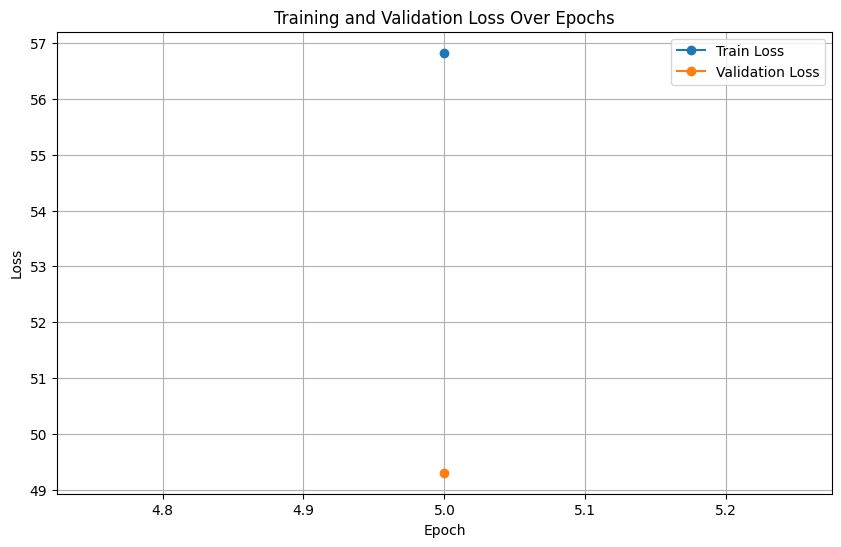

In [ ]:
t_loss, v_loss = train_final(dataset, vald_dataset)

## Analysis and testing

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss = 0
    n_batches = 0
    actions = define_actions(actions_to_consider_test)
    dim_used = np.array([ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                          26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                          46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                          75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92 ])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])

    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal*3, joint_equal*3+1, joint_equal*3+2))
    totalll = 0
    counter = 0
    for action in actions:
      running_loss = 0
      n = 0
      dataset_test = datasets.Datasets(path, input_n, 25, skip_rate, split=2, actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          all_joints_seq=batch.clone()[:, input_n:input_n+25,:]

          # GET SPEED REPRESENTATION OF THE FIRST FRAMES:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train1=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),batch[:,1:input_n,dim_used]-batch[:,:(input_n-1),dim_used]),1)
          sequences_gt=batch[:,10:35,:]


          running_time = time.time()
          sequences_predict1 = model(sequences_train1)

          # COME BACK POSITIONAL REPRESENTATION OF THE FIRST PREDICTION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict1[:,1:output_n,:]=sequences_predict1[:,1:output_n,:]+sequences_predict1[:,:(output_n-1),:]
          sequences_predict1=(sequences_predict1+batch[:,(input_n-1):input_n,dim_used])

          # GET SPEED REPRESENTATION OF THE PREDICTED STEPS:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train2=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),
                                     sequences_predict1[:,6:15,:]-sequences_predict1[:,5:14,:]),1)

          sequences_predict2=model(sequences_train2)

          # COME BACK POSITIONAL REPRESENTATION OF THE SECOND PREDICTION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict2[:,1:output_n,:]=sequences_predict2[:,1:output_n,:]+sequences_predict2[:,:(output_n-1),:]
          sequences_predict2=(sequences_predict2+sequences_predict1[:,(output_n-1):output_n,:])

          # STACK THE TWO PREDICTED SEQUENCES
          sequences_predict = torch.cat((sequences_predict1,sequences_predict2[:,:10,:]),1)

          totalll += time.time()-running_time
          counter += 1

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss = mpjpe_error(all_joints_seq.view(-1,25,32,3),sequences_gt.view(-1,25,32,3))
          running_loss += loss*batch_dim
          accum_loss += loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: ' + str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)

In [ ]:
path = './data/h3.6m/h3.6m/dataset'
skip_rate = 1
batch_size_test = 8
actions_to_consider_test = 'all'
ckpt_path = './checkpoints/LSTM_final_checkpoint_5.pt'

test(ckpt_path)

model loaded
walking :  64.6
eating :  50.5
smoking :  48.7
discussion :  83.2
directions :  72.3
greeting :  101.9
phoning :  67.0
posing :  104.8
purchases :  92.7
sitting :  70.7
sittingdown :  93.5
takingphoto :  68.5
waiting :  74.5
walkingdog :  104.4
walkingtogether :  54.5
Average: 76.8
Prediction time:  0.020222110549608867


# Bayesian LSTM version
- Encoder: Transformer + CNN
- Decoder: Bayesian LSTM

In [ ]:
!pip install blitz-bayesian-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
# to use the blitz-bayesian library
from blitz.modules import BayesianLinear
from blitz.modules import BayesianLSTM

In [ ]:
# to use the bayesian-torch library
from bayesian_torch.layers import LinearReparameterization as BayesianLinear
from bayesian_torch.layers import LSTMReparameterization as BayesianLSTM

## Definition

### Encoder

In [ ]:
class Attention(nn.Module):
    # CLASSICAL ATTENTION MECHANISM
    # IT'S THE SAME OF THE TEORICAL PART

    def __init__(self, attn_dropout):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)
    def forward(self, query, key, value, mask=None):
        attn = torch.matmul(query, key.transpose(-2, -1))
        d_k = query.size(-1)
        attn = attn / (d_k ** 0.5)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(F.softmax(attn,-1))
        output = torch.matmul(attn, value)
        return output, attn

In [ ]:
class MultiHeadAttention(nn.Module):
    # ALSO THE MULTIHEAD ATTENTION MECHANISM IS THE SAME OF TEORICAL PART

    def __init__(self, num_heads, d_model, dropout):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        #  We assume d_v always equals d_k
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.query_ff = nn.Linear(d_model, d_model)
        self.key_ff = nn.Linear(d_model, d_model)
        self.value_ff = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.attention = Attention(attn_dropout=dropout)
    def forward(self, query, key, value, mask=None, return_attention=False):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query = self.query_ff(query).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.key_ff(key).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_ff(value).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        x, self.attn = self.attention(query, key, value, mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)
        if return_attention:
            return self.attn_ff(x), self.attn
        return x

In [ ]:
class EncoderBlock(nn.Module):
    # THE ENCODER BLOCK IS A TIPICAL TRANSFORMER ENCODER,
    # BUT WE HAVE ADDED A CONVOLUTIONAL LAYER AT THE END:
    # self.conv IS USED TO SHRINK THE INFORMATION ALONG THE ENCODER BLOCKS
    # THIS IS A METHOD TO DISTILL INFORMATION SHOULD BE PASSED TO THE DECODER
    # AND MOREOVER TO SAVE A LOT OF TIME

    def __init__(self,num_heads,d_model,time_in,time_out,num_joints,dropout):
        super().__init__()

        self.num_joints = num_joints
        self.d_model = d_model

        self.self_attn = MultiHeadAttention(num_heads, d_model, dropout)

        # LAYERNORM LAYERS AND DROPOUT
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        # MLP
        self.lin_net = nn.Sequential(
            nn.Linear(d_model,2*d_model),
            nn.ReLU(),
            nn.Linear(2*d_model,d_model),
            nn.ReLU()
        )

        # A CNN SHRINKS THE FRAMES FROM time_it TO time_out
        # AND THE d_model IS HALVED AFTER EACH BLOCK
        self.conv = nn.Conv1d(time_in,time_out,3,padding=1)

    def forward(self, xs, mask=None):
        x = xs
        att = self.self_attn(x, x, x, mask)
        x = self.relu(x + att)
        x = self.norm1(x)

        lin_output = self.lin_net(x)
        x = self.relu(x + self.dropout(lin_output))

        # WE ADD A RESIDUAL CONNECTION ALSO HERE
        # IT REDUCES A BIT THE VANISH GRADIENT
        x = self.norm2(x + xs)

        # SHRINK
        x = self.conv(x)

        return x

### Decoder

In [ ]:
class Decoder(nn.Module):
    # THE DECODER BLOCK IS A SIMPLE LSTM,
    # WHICH TAKES THE DISTILLED INFORMATION FROM THE
    # ENCODER AS HIDDEN STATE AND AUTOREGRESSIVLY
    # FORSEES THE NEXT FRAMES
    def __init__(self, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        # LSTM
        self.lstm = BayesianLSTM(66, hidden_dim)
        # LINEAR self.out TO RETURN THE ORIGINAL DIMENSIONS
        self.out = nn.Linear(hidden_dim, 66)

    def forward(self, hidden, num_steps):
        # CELL STATE IS INITIALIZED TO ZEROS
        cell = nn.Parameter(torch.zeros(*hidden.shape)).to(device)
        batch_size = hidden.size(1)
        # THE <START> IS INITIALIZED TO ONES
        input = torch.ones((batch_size,66), dtype=torch.float).unsqueeze(0).to(device)
        outputs = torch.zeros((num_steps,batch_size,66), dtype=torch.float).to(device)

        for t in range(num_steps):
            # FORCAST
            decoder_output, (_,_) = self.lstm(input) # if blitz-bayesian library
            #decoder_output, _, kl = self.lstm(input) # if bayesian-torch library
            # SET TO THE ORIGINAL DIMENSIONS
            decoder_output = self.out(decoder_output[-1])
            outputs[t] = decoder_output
            # STACK TO THE INPUT
            input = torch.cat((input,decoder_output.unsqueeze(0)),0)
        return outputs

### Model

In [ ]:
def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')

In [ ]:
def fc_init(fc):
    nn.init.kaiming_normal_(fc.weight, nonlinearity='relu')

In [ ]:
def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

In [ ]:
class Model(nn.Module):
    # THIS IS THE FINAL MODEL IN WHICH WE MERGED THE ENCODER AND DECODER PARTS
    def __init__(self, num_channels, num_frames_out,
                 old_frames, num_joints, num_heads, drop,
                 d_model = 512, config=None):
        super().__init__()

        # CONFIGURATION FOR THE ENCODER BLOCKS
        if config==None:
            self.config = [[d_model,10,8],[d_model,8,6],[d_model,6,4],[d_model,4,2],[d_model,2,1]]

        self.num_channels = num_channels
        self.num_frames_out = num_frames_out
        self.num_heads = num_heads
        self.num_joints = num_joints
        self.old_frames = old_frames
        self.d_model = d_model

        # LINEAR BLOCK TO PASS FROM INITIAL DIMENSION 66 TO d_model
        self.lin = nn.Sequential(nn.Linear(self.num_channels*self.num_joints,d_model),nn.BatchNorm1d(self.old_frames))
        self.norm = nn.BatchNorm2d(self.num_channels)

        # ENCODER
        self.blocks = nn.ModuleList()
        # d_ : d_model of the block;
        # in_ : number of frames of the sequences at the begin;
        # out_ : number of frames of the sequences at the end
        for index, (d_,in_,out_) in enumerate(self.config):
            self.blocks.append(EncoderBlock(num_heads=self.num_heads,
                                            d_model=d_, time_in=in_, time_out=out_,
                                            num_joints=self.num_joints,dropout=drop))

        # SINUSOIDAL POSITIONAL EMBEDDINGS
        self.pos = Pos_Embed(self.num_channels,self.old_frames,self.num_joints)
        # DECODER: HIDDEN STATE DIMENSION IS THE DIMENSION OF THE LAST ENCODER
        self.dec = Decoder(self.d_model)

        # WEIGHTS INITIALIZATION
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            if isinstance(m, nn.Conv1d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m,1)
            elif isinstance(m, nn.BatchNorm1d):
                bn_init(m,1)
            elif isinstance(m, nn.Linear):
                fc_init(m)

    def forward(self,x):
        x = x.view(-1,self.old_frames,self.num_joints,self.num_channels).permute(0,3,1,2)
        # SUM POSITIONAL EMBEDDING
        x = (x + self.pos(x)).permute(0,2,3,1).view(-1,self.old_frames,self.num_joints*self.num_channels)
        # LINEAR LAYER
        x = self.lin(x)
        # ENCODER BLOCKS
        for i, block in enumerate(self.blocks):
            x = block(x)
        # RETRIEVE CONTEXT FROM THE ENCODER
        context = x.view(-1,self.d_model).unsqueeze(0)
        # PASS TO THE DECODER AND RETURN THE RESULTS
        results = self.dec(hidden = context,num_steps = self.num_frames_out)
        results = results.permute(1,0,2)
        return results

## Training

In [ ]:
# Argument for training
n_epochs = 5
log_step = 50
input_n = 10
output_n = 15

# The model name to save/load
datas = 'h36m'
model_path = datas + '_3d_' + str(output_n) + 'frames_ckpt'

model = Model(num_channels=3,
              num_frames_out=output_n,
              old_frames=input_n,
              num_joints=22,
              num_heads=8,
              drop=0.3).to(device)

# Arguments to setup the optimizer
lr = 5e-04 # learning rate
use_scheduler = True # use MultiStepLR scheduler
milestones = [2, 2, 2, 5, 5]   # the epochs after which the learning rate is adjusted by gamma
gamma = 0.5 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay = 0.00003 # weight decay (L2 penalty)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [ ]:
# WE HAVE REWRITE THE TRAIN FUNCTION
# TO IMPLEMENT THE SPEED REPRESENTATION

save_and_plot = False
def train_final(data_loader, vald_loader, clip_grad=None):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  # Initialize lists to store data from each checkpoint
  train_losses = []
  val_losses = []

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs):
      running_loss = 0
      n = 0
      model.train()
      for cnt, batch in enumerate(data_loader):
          batch = batch.float().to(device)
          batch_dim = batch.shape[0]
          n += batch_dim

          # GET SPEED REPRESENTATION:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train = torch.cat((torch.zeros(*batch[:, :1, dim_used].size()).to(device),batch[:, 1:10, dim_used]-batch[:, :9, dim_used]), 1)
          sequences_gt = batch[:, input_n:input_n + output_n, dim_used]

          optimizer.zero_grad()
          sequences_predict=model(sequences_train)
          # COME BACK POSITIONAL REPRESENTATION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :output_n-1, :]
          sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])


          loss = mpjpe_error(sequences_predict, sequences_gt) / output_n


          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  Training loss: %.3f' %(epoch+1, cnt+1, loss.item()*output_n))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim*output_n

      train_loss.append(running_loss.detach().cpu()/n)
      model.eval()
      with torch.no_grad():
          running_loss = 0
          n = 0
          for cnt, batch in enumerate(vald_loader):
              batch = batch.float().to(device)
              batch_dim = batch.shape[0]
              n += batch_dim

              # GET SPEED REPRESENTATION:
              # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
              # Y_{N+1} = X_{N+1} - X_{N}
              sequences_train = torch.cat((torch.zeros(*batch[:, :1, dim_used].size()).to(device), batch[:, 1:input_n, dim_used] - batch[:, :input_n-1, dim_used]), 1)
              sequences_gt = batch[:, input_n:input_n + output_n, dim_used]

              sequences_predict = model(sequences_train)

              # COME BACK POSITIONAL REPRESENTATION:
              # SUM EACH FRAME TO THE NEXT
              # X_{N+1} = Y_{N+1} + Y_{N}
              # ADD THE LAST FRAME OF THE TRAIN ONES
              sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :(output_n-1), :]
              sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])
              loss = mpjpe_error(sequences_predict, sequences_gt) / output_n

              if cnt % log_step == 0:
                print('[Epoch: %d, Iteration: %5d]  Validation loss: %.3f' %(epoch+1, cnt+1, loss.item()*output_n))
              running_loss += loss * batch_dim * output_n
          val_loss.append(running_loss.detach().cpu()/n)
          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n
          if (epoch+1) % 5 == 0:
            torch.save(model.state_dict(), './checkpoints/LSTM_final_checkpoint_' + str(epoch+1) + '.pt')
            train_losses.append(train_loss[-1])
            val_losses.append(val_loss[-1])

  if use_scheduler:
    scheduler.step()

  epochs=[5]#,10,15,20]

  # Create the plot
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')

  plt.legend()

  # Display the plot
  plt.grid(True)
  plt.show()
  return train_losses, val_losses

In [ ]:
t_loss, v_loss = train_final(dataset, vald_dataset)

### Analysis and test

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss = 0
    n_batches = 0
    actions = define_actions(actions_to_consider_test)
    dim_used = np.array([ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                          26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                          46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                          75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92 ])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])

    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal*3, joint_equal*3+1, joint_equal*3+2))
    totalll = 0
    counter = 0
    for action in actions:
      running_loss = 0
      n = 0
      dataset_test = datasets.Datasets(path, input_n, 25, skip_rate, split=2, actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          all_joints_seq=batch.clone()[:, input_n:input_n+25,:]

          # GET SPEED REPRESENTATION OF THE FIRST FRAMES:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train1=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),batch[:,1:input_n,dim_used]-batch[:,:(input_n-1),dim_used]),1)
          sequences_gt=batch[:,10:35,:]


          running_time = time.time()
          sequences_predict1 = model(sequences_train1)

          # COME BACK POSITIONAL REPRESENTATION OF THE FIRST PREDICTION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict1[:,1:output_n,:]=sequences_predict1[:,1:output_n,:]+sequences_predict1[:,:(output_n-1),:]
          sequences_predict1=(sequences_predict1+batch[:,(input_n-1):input_n,dim_used])

          # GET SPEED REPRESENTATION OF THE PREDICTED STEPS:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train2=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),
                                     sequences_predict1[:,6:15,:]-sequences_predict1[:,5:14,:]),1)

          sequences_predict2=model(sequences_train2)

          # COME BACK POSITIONAL REPRESENTATION OF THE SECOND PREDICTION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict2[:,1:output_n,:]=sequences_predict2[:,1:output_n,:]+sequences_predict2[:,:(output_n-1),:]
          sequences_predict2=(sequences_predict2+sequences_predict1[:,(output_n-1):output_n,:])

          # STACK THE TWO PREDICTED SEQUENCES
          sequences_predict = torch.cat((sequences_predict1,sequences_predict2[:,:10,:]),1)

          totalll += time.time()-running_time
          counter += 1

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss = mpjpe_error(all_joints_seq.view(-1,25,32,3),sequences_gt.view(-1,25,32,3))
          running_loss += loss*batch_dim
          accum_loss += loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: ' + str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)

In [ ]:
path = './data/h3.6m/h3.6m/dataset'
skip_rate = 1
batch_size_test = 8
actions_to_consider_test = 'all'
ckpt_path = './checkpoints/LSTM_final_checkpoint_5.pt'

test(ckpt_path)

# Bayesian GRU version
- Encoder: Transformer + CNN
- Decoder: Bayesian GRU

In [ ]:
!pip install blitz-bayesian-pytorch

In [ ]:
from blitz.modules import BayesianLinear
from blitz.modules import BayesianGRU

## Definition

### Encoder

In [ ]:
class Attention(nn.Module):
    # CLASSICAL ATTENTION MECHANISM
    # IT'S THE SAME OF THE TEORICAL PART

    def __init__(self, attn_dropout):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)
    def forward(self, query, key, value, mask=None):
        attn = torch.matmul(query, key.transpose(-2, -1))
        d_k = query.size(-1)
        attn = attn / (d_k ** 0.5)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(F.softmax(attn,-1))
        output = torch.matmul(attn, value)
        return output, attn

In [ ]:
class MultiHeadAttention(nn.Module):
    # ALSO THE MULTIHEAD ATTENTION MECHANISM IS THE SAME OF TEORICAL PART

    def __init__(self, num_heads, d_model, dropout):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        #  We assume d_v always equals d_k
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.query_ff = nn.Linear(d_model, d_model)
        self.key_ff = nn.Linear(d_model, d_model)
        self.value_ff = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.attention = Attention(attn_dropout=dropout)
    def forward(self, query, key, value, mask=None, return_attention=False):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query = self.query_ff(query).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.key_ff(key).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_ff(value).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        x, self.attn = self.attention(query, key, value, mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)
        if return_attention:
            return self.attn_ff(x), self.attn
        return x

In [ ]:
class EncoderBlock(nn.Module):
    # THE ENCODER BLOCK IS A TIPICAL TRANSFORMER ENCODER,
    # BUT WE HAVE ADDED A CONVOLUTIONAL LAYER AT THE END:
    # self.conv IS USED TO SHRINK THE INFORMATION ALONG THE ENCODER BLOCKS
    # THIS IS A METHOD TO DISTILL INFORMATION SHOULD BE PASSED TO THE DECODER
    # AND MOREOVER TO SAVE A LOT OF TIME

    def __init__(self,num_heads,d_model,time_in,time_out,num_joints,dropout):
        super().__init__()

        self.num_joints = num_joints
        self.d_model = d_model

        self.self_attn = MultiHeadAttention(num_heads, d_model, dropout)

        # LAYERNORM LAYERS AND DROPOUT
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        # MLP
        self.lin_net = nn.Sequential(
            nn.Linear(d_model,2*d_model),
            nn.ReLU(),
            nn.Linear(2*d_model,d_model),
            nn.ReLU()
        )

        # A CNN SHRINKS THE FRAMES FROM time_it TO time_out
        # AND THE d_model IS HALVED AFTER EACH BLOCK
        self.conv = nn.Conv1d(time_in,time_out,3,padding=1)

    def forward(self, xs, mask=None):
        x = xs
        att = self.self_attn(x, x, x, mask)
        x = self.relu(x + att)
        x = self.norm1(x)

        lin_output = self.lin_net(x)
        x = self.relu(x + self.dropout(lin_output))

        # WE ADD A RESIDUAL CONNECTION ALSO HERE
        # IT REDUCES A BIT THE VANISH GRADIENT
        x = self.norm2(x + xs)

        # SHRINK
        x = self.conv(x)

        return x

### Decoder

In [ ]:
class Decoder(nn.Module):
    # THE DECODER BLOCK IS A SIMPLE GRU,
    # WHICH TAKES THE DISTILLED INFORMATION FROM THE
    # ENCODER AS HIDDEN STATE AND AUTOREGRESSIVLY
    # FORSEES THE NEXT FRAMES
    def __init__(self, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        # GRU
        self.gru = BayesianGRU(66, hidden_dim)
        # LINEAR self.out TO RETURN THE ORIGINAL DIMENSIONS
        self.out = nn.Linear(hidden_dim, 66)

    def forward(self, hidden, num_steps):
        # CELL STATE IS INITIALIZED TO ZEROS
        cell = nn.Parameter(torch.zeros(*hidden.shape)).to(device)
        batch_size = hidden.size(1)
        # THE <START> IS INITIALIZED TO ONES
        input = torch.ones((batch_size,66), dtype=torch.float).unsqueeze(0).to(device)
        outputs = torch.zeros((num_steps,batch_size,66), dtype=torch.float).to(device)

        for t in range(num_steps):
            # FORCAST
            decoder_output, _ = self.gru(input)
            # SET TO THE ORIGINAL DIMENSIONS
            decoder_output = self.out(decoder_output[-1])
            outputs[t] = decoder_output
            # STACK TO THE INPUT
            input = torch.cat((input,decoder_output.unsqueeze(0)),0)
        return outputs

### Model

In [ ]:
def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')

In [ ]:
def fc_init(fc):
    nn.init.kaiming_normal_(fc.weight, nonlinearity='relu')

In [ ]:
def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

In [ ]:
class Model(nn.Module):
    # THIS IS THE FINAL MODEL IN WHICH WE MERGED THE ENCODER AND DECODER PARTS
    def __init__(self, num_channels, num_frames_out,
                 old_frames, num_joints, num_heads, drop,
                 d_model = 512, config=None):
        super().__init__()

        # CONFIGURATION FOR THE ENCODER BLOCKS
        if config==None:
            self.config = [[d_model,10,8],[d_model,8,6],[d_model,6,4],[d_model,4,2],[d_model,2,1]]

        self.num_channels = num_channels
        self.num_frames_out = num_frames_out
        self.num_heads = num_heads
        self.num_joints = num_joints
        self.old_frames = old_frames
        self.d_model = d_model

        # LINEAR BLOCK TO PASS FROM INITIAL DIMENSION 66 TO d_model
        self.lin = nn.Sequential(nn.Linear(self.num_channels*self.num_joints,d_model),nn.BatchNorm1d(self.old_frames))
        self.norm = nn.BatchNorm2d(self.num_channels)

        # ENCODER
        self.blocks = nn.ModuleList()
        # d_ : d_model of the block;
        # in_ : number of frames of the sequences at the begin;
        # out_ : number of frames of the sequences at the end
        for index, (d_,in_,out_) in enumerate(self.config):
            self.blocks.append(EncoderBlock(num_heads=self.num_heads,
                                            d_model=d_, time_in=in_, time_out=out_,
                                            num_joints=self.num_joints,dropout=drop))

        # SINUSOIDAL POSITIONAL EMBEDDINGS
        self.pos = Pos_Embed(self.num_channels,self.old_frames,self.num_joints)
        # DECODER: HIDDEN STATE DIMENSION IS THE DIMENSION OF THE LAST ENCODER
        self.dec = Decoder(self.d_model)

        # WEIGHTS INITIALIZATION
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            if isinstance(m, nn.Conv1d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m,1)
            elif isinstance(m, nn.BatchNorm1d):
                bn_init(m,1)
            elif isinstance(m, nn.Linear):
                fc_init(m)

    def forward(self,x):
        x = x.view(-1,self.old_frames,self.num_joints,self.num_channels).permute(0,3,1,2)
        # SUM POSITIONAL EMBEDDING
        x = (x + self.pos(x)).permute(0,2,3,1).view(-1,self.old_frames,self.num_joints*self.num_channels)
        # LINEAR LAYER
        x = self.lin(x)
        # ENCODER BLOCKS
        for i, block in enumerate(self.blocks):
            x = block(x)
        # RETRIEVE CONTEXT FROM THE ENCODER
        context = x.view(-1,self.d_model).unsqueeze(0)
        # PASS TO THE DECODER AND RETURN THE RESULTS
        results = self.dec(hidden = context,num_steps = self.num_frames_out)
        results = results.permute(1,0,2)
        return results

## Training

In [ ]:
# Argument for training
n_epochs = 5
log_step = 50
input_n = 10
output_n = 15

# The model name to save/load
datas = 'h36m'
model_path = datas + '_3d_' + str(output_n) + 'frames_ckpt'

model = Model(num_channels=3,
              num_frames_out=output_n,
              old_frames=input_n,
              num_joints=22,
              num_heads=8,
              drop=0.3).to(device)

# Arguments to setup the optimizer
lr = 5e-04 # learning rate
use_scheduler = True # use MultiStepLR scheduler
milestones = [2, 2, 2, 5, 5]   # the epochs after which the learning rate is adjusted by gamma
gamma = 0.5 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay = 0.00003 # weight decay (L2 penalty)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [ ]:
# WE HAVE REWRITE THE TRAIN FUNCTION
# TO IMPLEMENT THE SPEED REPRESENTATION

save_and_plot = False
def train_final(data_loader, vald_loader, clip_grad=None):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  # Initialize lists to store data from each checkpoint
  train_losses = []
  val_losses = []

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs):
      running_loss = 0
      n = 0
      model.train()
      for cnt, batch in enumerate(data_loader):
          batch = batch.float().to(device)
          batch_dim = batch.shape[0]
          n += batch_dim

          # GET SPEED REPRESENTATION:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train = torch.cat((torch.zeros(*batch[:, :1, dim_used].size()).to(device),batch[:, 1:10, dim_used]-batch[:, :9, dim_used]), 1)
          sequences_gt = batch[:, input_n:input_n + output_n, dim_used]

          optimizer.zero_grad()
          sequences_predict=model(sequences_train)
          # COME BACK POSITIONAL REPRESENTATION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :output_n-1, :]
          sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])


          loss = mpjpe_error(sequences_predict, sequences_gt) / output_n


          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  Training loss: %.3f' %(epoch+1, cnt+1, loss.item()*output_n))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim*output_n

      train_loss.append(running_loss.detach().cpu()/n)
      model.eval()
      with torch.no_grad():
          running_loss = 0
          n = 0
          for cnt, batch in enumerate(vald_loader):
              batch = batch.float().to(device)
              batch_dim = batch.shape[0]
              n += batch_dim

              # GET SPEED REPRESENTATION:
              # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
              # Y_{N+1} = X_{N+1} - X_{N}
              sequences_train = torch.cat((torch.zeros(*batch[:, :1, dim_used].size()).to(device), batch[:, 1:input_n, dim_used] - batch[:, :input_n-1, dim_used]), 1)
              sequences_gt = batch[:, input_n:input_n + output_n, dim_used]

              sequences_predict = model(sequences_train)

              # COME BACK POSITIONAL REPRESENTATION:
              # SUM EACH FRAME TO THE NEXT
              # X_{N+1} = Y_{N+1} + Y_{N}
              # ADD THE LAST FRAME OF THE TRAIN ONES
              sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :(output_n-1), :]
              sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])
              loss = mpjpe_error(sequences_predict, sequences_gt) / output_n

              if cnt % log_step == 0:
                print('[Epoch: %d, Iteration: %5d]  Validation loss: %.3f' %(epoch+1, cnt+1, loss.item()*output_n))
              running_loss += loss * batch_dim * output_n
          val_loss.append(running_loss.detach().cpu()/n)
          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n
          if (epoch+1) % 5 == 0:
            torch.save(model.state_dict(), './checkpoints/LSTM_final_checkpoint_' + str(epoch+1) + '.pt')
            train_losses.append(train_loss[-1])
            val_losses.append(val_loss[-1])

  if use_scheduler:
    scheduler.step()

  epochs=[5]#,10,15,20]

  # Create the plot
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')

  plt.legend()

  # Display the plot
  plt.grid(True)
  plt.show()
  return train_losses,val_losses

In [ ]:
t_loss, v_loss = train_final(dataset, vald_dataset)

[Epoch: 1, Iteration:     1]  Training loss: 77.170
[Epoch: 1, Iteration:    51]  Training loss: 84.953
[Epoch: 1, Iteration:   101]  Training loss: 80.441
[Epoch: 1, Iteration:   151]  Training loss: 63.808
[Epoch: 1, Iteration:   201]  Training loss: 76.087
[Epoch: 1, Iteration:   251]  Training loss: 75.209
[Epoch: 1, Iteration:   301]  Training loss: 82.337
[Epoch: 1, Iteration:   351]  Training loss: 72.179
[Epoch: 1, Iteration:   401]  Training loss: 72.022


KeyboardInterrupt: ignored

### Analysis and test

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss = 0
    n_batches = 0
    actions = define_actions(actions_to_consider_test)
    dim_used = np.array([ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                          26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                          46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                          75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92 ])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])

    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal*3, joint_equal*3+1, joint_equal*3+2))
    totalll = 0
    counter = 0
    for action in actions:
      running_loss = 0
      n = 0
      dataset_test = datasets.Datasets(path, input_n, 25, skip_rate, split=2, actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          all_joints_seq=batch.clone()[:, input_n:input_n+25,:]

          # GET SPEED REPRESENTATION OF THE FIRST FRAMES:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train1=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),batch[:,1:input_n,dim_used]-batch[:,:(input_n-1),dim_used]),1)
          sequences_gt=batch[:,10:35,:]


          running_time = time.time()
          sequences_predict1 = model(sequences_train1)

          # COME BACK POSITIONAL REPRESENTATION OF THE FIRST PREDICTION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict1[:,1:output_n,:]=sequences_predict1[:,1:output_n,:]+sequences_predict1[:,:(output_n-1),:]
          sequences_predict1=(sequences_predict1+batch[:,(input_n-1):input_n,dim_used])

          # GET SPEED REPRESENTATION OF THE PREDICTED STEPS:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train2=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),
                                     sequences_predict1[:,6:15,:]-sequences_predict1[:,5:14,:]),1)

          sequences_predict2=model(sequences_train2)

          # COME BACK POSITIONAL REPRESENTATION OF THE SECOND PREDICTION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict2[:,1:output_n,:]=sequences_predict2[:,1:output_n,:]+sequences_predict2[:,:(output_n-1),:]
          sequences_predict2=(sequences_predict2+sequences_predict1[:,(output_n-1):output_n,:])

          # STACK THE TWO PREDICTED SEQUENCES
          sequences_predict = torch.cat((sequences_predict1,sequences_predict2[:,:10,:]),1)

          totalll += time.time()-running_time
          counter += 1

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss = mpjpe_error(all_joints_seq.view(-1,25,32,3),sequences_gt.view(-1,25,32,3))
          running_loss += loss*batch_dim
          accum_loss += loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: ' + str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)

In [ ]:
path = './data/h3.6m/h3.6m/dataset'
skip_rate = 1
batch_size_test = 8
actions_to_consider_test = 'all'
ckpt_path = './checkpoints/LSTM_final_checkpoint_5.pt'

test(ckpt_path)

# Final Model
- Encoder: Transfomer + CNN
- Decoder: GRU + CNN + Linear

## Definition

### Encoder

In [ ]:
class Attention(nn.Module):

    def __init__(self, attn_dropout):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, query, key, value, mask=None):
        attn = torch.matmul(query, key.transpose(-2, -1))
        d_k = query.size(-1)
        attn = attn / (d_k ** 0.5)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(F.softmax(attn,-1))
        output = torch.matmul(attn, value)
        return output, attn

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, d_model, dropout):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.query_ff = nn.Linear(d_model, d_model)
        self.key_ff = nn.Linear(d_model, d_model)
        self.value_ff = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.attention = Attention(attn_dropout=dropout)

    def forward(self, query, key, value, mask=None, return_attention=False):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query = self.query_ff(query).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.key_ff(key).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_ff(value).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        x, self.attn = self.attention(query, key, value, mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)
        if return_attention:
            return self.attn_ff(x), self.attn
        return x

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, num_heads, d_model, time_in, time_out, num_joints, dropout):
        super().__init__()

        self.num_joints = num_joints
        self.d_model = d_model

        self.self_attn = MultiHeadAttention(num_heads, d_model, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        self.lin_net = nn.Sequential(
            nn.Linear(d_model, 2*d_model),
            nn.ReLU(),
            nn.Linear(2*d_model, d_model),
            nn.ReLU()
        )

        self.conv = nn.Conv1d(time_in, time_out, 3, padding=1)

    def forward(self, xs, mask=None):
        x = xs
        att = self.self_attn(x, x, x, mask)
        x = self.relu(x + att)
        x = self.norm1(x)

        lin_output = self.lin_net(x)
        x = self.relu(x + self.dropout(lin_output))
        x = self.norm2(x + xs)
        x = self.conv(x)

        return x

### Decoder

In [ ]:
class Decoder(nn.Module):

    def __init__(self, hidden_dim, num_layers=1, conv_channels=128, kernel_size=3):
        super(Decoder, self).__init__()

        self.gru = nn.GRU(66, hidden_dim, num_layers=num_layers, dropout=0.3)
        self.conv1d = nn.Conv1d(hidden_dim, conv_channels, kernel_size, padding=1)
        self.out = nn.Linear(conv_channels, 66)

    def forward(self, hidden, num_steps):
        cell = nn.Parameter(torch.zeros(*hidden.shape)).to(device)
        batch_size = hidden.size(1)
        input = torch.zeros((batch_size, 66), dtype=torch.float).unsqueeze(0).to(device)
        outputs = torch.zeros((num_steps, batch_size, 66), dtype=torch.float).to(device)

        for t in range(num_steps):
            decoder_output, _ = self.gru(input, hidden)
            decoder_output = decoder_output.permute(0, 2, 1)
            decoder_output = F.relu(self.conv1d(decoder_output))
            decoder_output = decoder_output.permute(0, 2, 1)
            decoder_output = self.out(decoder_output[-1])
            outputs[t] = decoder_output
            input = torch.cat((input, decoder_output.unsqueeze(0)), 0)

        return outputs

### Model

In [ ]:
def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')

In [ ]:
def fc_init(fc):
    nn.init.kaiming_normal_(fc.weight, nonlinearity='relu')

In [ ]:
def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

In [ ]:
class Model(nn.Module):

    def __init__(self, num_channels, num_frames_out,
                 old_frames, num_joints, num_heads, drop,
                 d_model = 512, config=None):
        super().__init__()

        if config==None:
            self.config = [[d_model,10,8],[d_model,8,6],[d_model,6,4],[d_model,4,2],[d_model,2,1]]

        self.num_channels = num_channels
        self.num_frames_out = num_frames_out
        self.num_heads = num_heads
        self.num_joints = num_joints
        self.old_frames = old_frames
        self.d_model = d_model

        self.lin = nn.Sequential(nn.Linear(self.num_channels*self.num_joints,d_model),nn.BatchNorm1d(self.old_frames))
        self.norm = nn.BatchNorm2d(self.num_channels)

        self.blocks = nn.ModuleList()

        for index, (d_, in_, out_) in enumerate(self.config):
            self.blocks.append(EncoderBlock(num_heads=self.num_heads,
                                            d_model=d_, time_in=in_, time_out=out_,
                                            num_joints=self.num_joints,dropout=drop))

        self.pos = Pos_Embed(self.num_channels,self.old_frames,self.num_joints)
        self.dec = Decoder(self.d_model)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            if isinstance(m, nn.Conv1d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m,1)
            elif isinstance(m, nn.BatchNorm1d):
                bn_init(m,1)
            elif isinstance(m, nn.Linear):
                fc_init(m)

    def forward(self,x):
        x = x.view(-1,self.old_frames,self.num_joints,self.num_channels).permute(0,3,1,2)
        x = (x + self.pos(x)).permute(0,2,3,1).view(-1,self.old_frames,self.num_joints*self.num_channels)
        x = self.lin(x)
        for i, block in enumerate(self.blocks):
            x = block(x)
        context = x.view(-1,self.d_model).unsqueeze(0)
        results = self.dec(hidden = context, num_steps=self.num_frames_out)
        results = results.permute(1,0,2)
        return results

## Training

In [ ]:
n_epochs = 20
log_step = 50
input_n = 10
output_n = 15
num_channels = 3
dropout = 0.3
num_joints = 22
num_heads = 16

datas = 'h36m'
model_path = datas + '_3d_' + str(output_n) + 'frames_ckpt'

model = Model(num_channels=num_channels,
              num_frames_out=output_n,
              old_frames=input_n,
              num_joints=num_joints,
              num_heads=num_heads,
              drop=dropout).to(device)


lr = 5e-04
use_scheduler = True
milestones = [1, 2, 3, 4, 5]   # the epochs after which the learning rate is adjusted by gamma
gamma = 0.5
weight_decay = 0.00003
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
save_and_plot = True

def train_final(data_loader, vald_loader, clip_grad=None):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  train_losses = []
  val_losses = []

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs):
      running_loss = 0
      n = 0
      best_epoch = None
      model.train()
      for cnt, batch in enumerate(data_loader):
          batch = batch.float().to(device)
          batch_dim = batch.shape[0]
          n += batch_dim

          sequences_train = torch.cat((torch.zeros(*batch[:, :1, dim_used].size()).to(device),batch[:, 1:10, dim_used]-batch[:, :9, dim_used]), 1)
          sequences_gt = batch[:, input_n:input_n + output_n, dim_used]

          optimizer.zero_grad()
          sequences_predict=model(sequences_train)
          sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :output_n-1, :]
          sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])

          loss = mpjpe_error(sequences_predict, sequences_gt) / output_n

          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  Training loss: %.3f' %(epoch+1, cnt+1, loss.item()*output_n))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim*output_n

      train_loss.append(running_loss.detach().cpu()/n)
      model.eval()
      with torch.no_grad():
          running_loss = 0
          n = 0
          for cnt, batch in enumerate(vald_loader):
              batch = batch.float().to(device)
              batch_dim = batch.shape[0]
              n += batch_dim

              sequences_train = torch.cat((torch.zeros(*batch[:, :1, dim_used].size()).to(device), batch[:, 1:input_n, dim_used] - batch[:, :input_n-1, dim_used]), 1)
              sequences_gt = batch[:, input_n:input_n + output_n, dim_used]

              sequences_predict = model(sequences_train)

              sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :(output_n-1), :]
              sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])
              loss = mpjpe_error(sequences_predict, sequences_gt) / output_n

              if cnt % log_step == 0:
                print('[Epoch: %d, Iteration: %5d]  Validation loss: %.3f' %(epoch+1, cnt+1, loss.item()*output_n))
              running_loss += loss * batch_dim * output_n
          val_loss.append(running_loss.detach().cpu()/n)
          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n
            torch.save(model.state_dict(), './checkpoints/LSTM_best_checkpoint_.pt')
          if (epoch+1) % 5 == 0:
            torch.save(model.state_dict(), './checkpoints/LSTM_final_checkpoint_' + str(epoch+1) + '.pt')
            train_losses.append(train_loss[-1])
            val_losses.append(val_loss[-1])

  if use_scheduler:
    scheduler.step()

  epochs=[5, 10, 15, 20]

  plt.figure(figsize=(10, 6))
  plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')

  plt.legend()

  plt.grid(True)
  plt.show()

  return train_losses, val_losses

[Epoch: 1, Iteration:     1]  Training loss: 80.238
[Epoch: 1, Iteration:    51]  Training loss: 81.367
[Epoch: 1, Iteration:   101]  Training loss: 69.467
[Epoch: 1, Iteration:   151]  Training loss: 76.238
[Epoch: 1, Iteration:   201]  Training loss: 66.220
[Epoch: 1, Iteration:   251]  Training loss: 68.963
[Epoch: 1, Iteration:   301]  Training loss: 67.997
[Epoch: 1, Iteration:   351]  Training loss: 63.256
[Epoch: 1, Iteration:   401]  Training loss: 67.212
[Epoch: 1, Iteration:   451]  Training loss: 61.753
[Epoch: 1, Iteration:   501]  Training loss: 63.126
[Epoch: 1, Iteration:   551]  Training loss: 59.127
[Epoch: 1, Iteration:   601]  Training loss: 58.307
[Epoch: 1, Iteration:   651]  Training loss: 59.067
[Epoch: 1, Iteration:   701]  Training loss: 59.266
[Epoch: 1, Iteration:     1]  Validation loss: 68.925
[Epoch: 1, Iteration:    51]  Validation loss: 19.360
[Epoch: 1, Iteration:   101]  Validation loss: 69.015
[Epoch: 2, Iteration:     1]  Training loss: 62.506
[Epoch

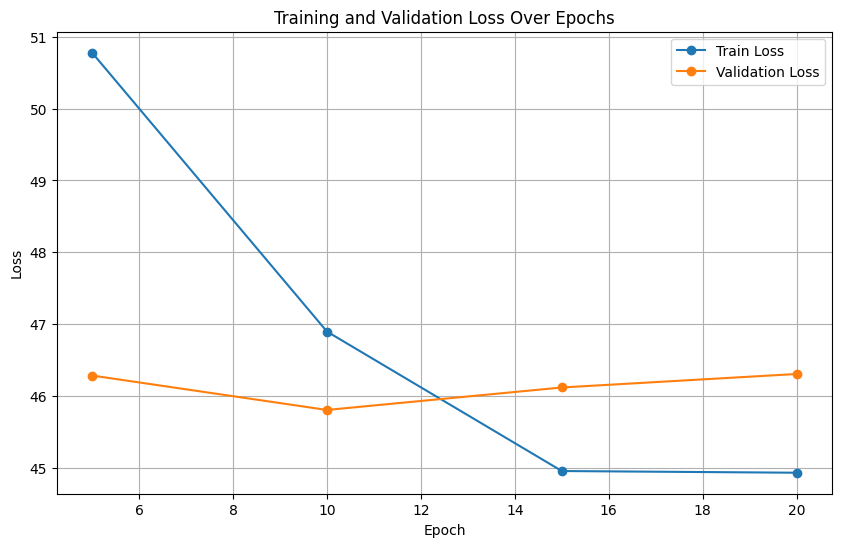

In [ ]:
t_loss, v_loss = train_final(dataset, vald_dataset)

### Analysis and test

In [ ]:
def test(ckpt_path=None):

    model.load_state_dict(torch.load(ckpt_path))
    print('Model loaded')

    model.eval()
    accum_loss = 0
    n_batches = 0
    actions = define_actions(actions_to_consider_test)
    dim_used = np.array([ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                          26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                          46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                          75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92 ])
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])

    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal*3, joint_equal*3+1, joint_equal*3+2))
    totalll = 0
    counter = 0
    for action in actions:
      running_loss = 0
      n = 0
      dataset_test = datasets.Datasets(path, input_n, 25, skip_rate, split=2, actions=[action])

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          all_joints_seq=batch.clone()[:, input_n:input_n+25,:]

          sequences_train1=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),batch[:,1:input_n,dim_used]-batch[:,:(input_n-1),dim_used]),1)
          sequences_gt=batch[:,10:35,:]


          running_time = time.time()
          sequences_predict1 = model(sequences_train1)

          sequences_predict1[:,1:output_n,:]=sequences_predict1[:,1:output_n,:]+sequences_predict1[:,:(output_n-1),:]
          sequences_predict1=(sequences_predict1+batch[:,(input_n-1):input_n,dim_used])

          sequences_train2=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),
                                     sequences_predict1[:,6:15,:]-sequences_predict1[:,5:14,:]),1)

          sequences_predict2=model(sequences_train2)

          sequences_predict2[:,1:output_n,:]=sequences_predict2[:,1:output_n,:]+sequences_predict2[:,:(output_n-1),:]
          sequences_predict2=(sequences_predict2+sequences_predict1[:,(output_n-1):output_n,:])

          sequences_predict = torch.cat((sequences_predict1,sequences_predict2[:,:10,:]),1)

          totalll += time.time()-running_time
          counter += 1

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss = mpjpe_error(all_joints_seq.view(-1, 25, 32, 3),sequences_gt.view(-1, 25, 32, 3))
          running_loss += loss*batch_dim
          accum_loss += loss*batch_dim

      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches += n
    print('Average: ' + str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)

In [ ]:
path = './data/h3.6m/h3.6m/dataset'
skip_rate = 1
batch_size_test = 8
actions_to_consider_test = 'all'
ckpt_path = './checkpoints/LSTM_best_checkpoint_.pt'

test(ckpt_path)

Model loaded
walking :  55.0
eating :  48.2
smoking :  48.0
discussion :  81.1
directions :  68.8
greeting :  95.1
phoning :  63.8
posing :  103.2
purchases :  91.6
sitting :  69.5
sittingdown :  91.2
takingphoto :  69.0
waiting :  71.0
walkingdog :  101.2
walkingtogether :  52.5
Average: 73.9
Prediction time:  0.027816305061181386


# Final Model Bayesian
- Encoder: Transfomer + CNN
- Decoder: GRU + BayesianCNN + BayesianLinear

In [7]:
from bayesian_torch.layers import LinearReparameterization as BayesianLinear
from bayesian_torch.layers import Conv1dReparameterization as BayesianConv1d

## Definition

### Encoder

In [8]:
class Attention(nn.Module):

    def __init__(self, attn_dropout):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, query, key, value, mask=None):
        attn = torch.matmul(query, key.transpose(-2, -1))
        d_k = query.size(-1)
        attn = attn / (d_k ** 0.5)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(F.softmax(attn,-1))
        output = torch.matmul(attn, value)
        return output, attn

In [9]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, d_model, dropout):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.query_ff = nn.Linear(d_model, d_model)
        self.key_ff = nn.Linear(d_model, d_model)
        self.value_ff = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.attention = Attention(attn_dropout=dropout)

    def forward(self, query, key, value, mask=None, return_attention=False):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query = self.query_ff(query).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.key_ff(key).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_ff(value).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        x, self.attn = self.attention(query, key, value, mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)
        if return_attention:
            return self.attn_ff(x), self.attn
        return x

In [10]:
class EncoderBlock(nn.Module):

    def __init__(self, num_heads, d_model, time_in, time_out, num_joints, dropout):
        super().__init__()

        self.num_joints = num_joints
        self.d_model = d_model

        self.self_attn = MultiHeadAttention(num_heads, d_model, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        self.lin_net = nn.Sequential(
            nn.Linear(d_model, 2*d_model),
            nn.ReLU(),
            nn.Linear(2*d_model, d_model),
            nn.ReLU()
        )

        self.conv = nn.Conv1d(time_in, time_out, 3, padding=1)

    def forward(self, xs, mask=None):
        x = xs
        att = self.self_attn(x, x, x, mask)
        x = self.relu(x + att)
        x = self.norm1(x)

        lin_output = self.lin_net(x)
        x = self.relu(x + self.dropout(lin_output))
        x = self.norm2(x + xs)
        x = self.conv(x)

        return x

### Decoder

In [11]:
class Decoder(nn.Module):

    def __init__(self, hidden_dim, num_layers=1, conv_channels=128, kernel_size=3):
        super(Decoder, self).__init__()

        self.gru = nn.GRU(66, hidden_dim, num_layers=num_layers)#, dropout=0.5)
        self.conv1d = BayesianConv1d(hidden_dim, conv_channels, kernel_size, padding=1)
        self.out = BayesianLinear(conv_channels, 66)

    def forward(self, hidden, num_steps):
        cell = nn.Parameter(torch.zeros(*hidden.shape)).to(device)
        batch_size = hidden.size(1)
        input = torch.zeros((batch_size, 66), dtype=torch.float).unsqueeze(0).to(device)
        outputs = torch.zeros((num_steps, batch_size, 66), dtype=torch.float).to(device)

        kl_loss = 0
        for t in range(num_steps):
            decoder_output, _ = self.gru(input, hidden)
            decoder_output = decoder_output.permute(0, 2, 1)
            decoder_output, kl_1 = self.conv1d(decoder_output)
            decoder_output = F.relu(decoder_output)
            decoder_output = decoder_output.permute(0, 2, 1)
            decoder_output, kl_2 = self.out(decoder_output[-1])
            outputs[t] = decoder_output
            input = torch.cat((input, decoder_output.unsqueeze(0)), 0)
            kl_loss += kl_loss + kl_1 + kl_2

        return outputs, kl_loss

### Model

In [12]:
def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')

In [13]:
def fc_init(fc):
    nn.init.kaiming_normal_(fc.weight, nonlinearity='relu')

In [14]:
def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

In [15]:
class Model(nn.Module):

    def __init__(self, num_channels, num_frames_out,
                 old_frames, num_joints, num_heads, drop,
                 d_model = 512, config=None):
        super().__init__()

        if config==None:
            self.config = [[d_model,10,8],[d_model,8,6],[d_model,6,4],[d_model,4,2],[d_model,2,1]]

        self.num_channels = num_channels
        self.num_frames_out = num_frames_out
        self.num_heads = num_heads
        self.num_joints = num_joints
        self.old_frames = old_frames
        self.d_model = d_model

        self.lin = nn.Sequential(nn.Linear(self.num_channels*self.num_joints,d_model),nn.BatchNorm1d(self.old_frames))
        self.norm = nn.BatchNorm2d(self.num_channels)

        self.blocks = nn.ModuleList()

        for index, (d_, in_, out_) in enumerate(self.config):
            self.blocks.append(EncoderBlock(num_heads=self.num_heads,
                                            d_model=d_, time_in=in_, time_out=out_,
                                            num_joints=self.num_joints,dropout=drop))

        self.pos = Pos_Embed(self.num_channels,self.old_frames,self.num_joints)
        self.dec = Decoder(self.d_model)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            if isinstance(m, nn.Conv1d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m,1)
            elif isinstance(m, nn.BatchNorm1d):
                bn_init(m,1)
            elif isinstance(m, nn.Linear):
                fc_init(m)

    def forward(self,x):
        x = x.view(-1,self.old_frames,self.num_joints,self.num_channels).permute(0,3,1,2)
        x = (x + self.pos(x)).permute(0,2,3,1).view(-1,self.old_frames,self.num_joints*self.num_channels)
        x = self.lin(x)
        for i, block in enumerate(self.blocks):
            x = block(x)
        context = x.view(-1,self.d_model).unsqueeze(0)
        results, kl_loss = self.dec(hidden = context, num_steps=self.num_frames_out)
        results = results.permute(1,0,2)
        return results, kl_loss

## Training

In [16]:
n_epochs = 10
log_step = 100
input_n = 10
output_n = 15
num_channels = 3
dropout = 0.3
num_joints = 22
num_heads = 8

datas = 'h36m'
model_path = datas + '_3d_' + str(output_n) + 'frames_ckpt'

model = Model(num_channels=num_channels,
              num_frames_out=output_n,
              old_frames=input_n,
              num_joints=num_joints,
              num_heads=num_heads,
              drop=dropout).to(device)

lr = 1e-04
use_scheduler = True
milestones = [3, 6, 9]
gamma = 0.7
weight_decay = 3e-04
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [39]:
save_and_plot = True

def train_final(data_loader, vald_loader, clip_grad=None):
  train_loss = []
  train_kl_loss = []
  val_loss = []
  val_kl_loss = []
  val_loss_best = 1000

  train_losses = []
  val_losses = []

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs):
      running_loss = 0
      n = 0
      best_epoch = None

      model.train()
      for cnt, batch in enumerate(data_loader):
          batch = batch.float().to(device)
          batch_dim = batch.shape[0]
          n += batch_dim

          sequences_train = torch.cat((torch.zeros(*batch[:, :1, dim_used].size()).to(device),batch[:, 1:10, dim_used]-batch[:, :9, dim_used]), 1)
          sequences_gt = batch[:, input_n:input_n + output_n, dim_used]

          optimizer.zero_grad()

          num_predictions = 100
          mean_predictions = torch.zeros((256, 15, 66)).to(device)
          mean_kl_loss = 0

          for i in range(num_predictions-1):
              with torch.no_grad():
                sequences_predict, kl_loss = model(sequences_train)
                sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :output_n-1, :]
                sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])
                mean_predictions += sequences_predict
                mean_kl_loss += kl_loss
          sequences_predict, kl_loss = model(sequences_train)
          sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :output_n-1, :]
          sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])
          mean_predictions += sequences_predict
          mean_kl_loss += kl_loss

          mean_predictions = mean_predictions / num_predictions
          mean_kl_loss = mean_kl_loss / num_predictions

          loss1 = mpjpe_error(mean_predictions, sequences_gt)
          kl_loss = mean_kl_loss / batch_dim
          loss = loss1 + kl_loss

          if cnt % log_step == 0:
            print('[Epoch: {:<2d} | Iteration: {:>5d}] Train | MPJPE loss: {:.3f} | KL loss: {:.3f} | Total loss: {:.3f}'.format(epoch + 1, cnt + 1, loss1, kl_loss, loss.item()))

          loss.backward()

          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

          optimizer.step()
          running_loss += loss * batch_dim

      train_loss.append(running_loss.detach().cpu()/n)
      #train_kl_loss.append()

      model.eval()
      with torch.no_grad():
          running_loss = 0
          n = 0
          for cnt, batch in enumerate(vald_loader):
              batch = batch.float().to(device)
              batch_dim = batch.shape[0]
              n += batch_dim

              sequences_train = torch.cat((torch.zeros(*batch[:, :1, dim_used].size()).to(device), batch[:, 1:input_n, dim_used] - batch[:, :input_n-1, dim_used]), 1)
              sequences_gt = batch[:, input_n:input_n + output_n, dim_used]

              sequences_predict, kl_loss = model(sequences_train)

              sequences_predict[:, 1:output_n, :] = sequences_predict[:, 1:output_n, :] + sequences_predict[:, :(output_n-1), :]
              sequences_predict = (sequences_predict + batch[:, (input_n-1):input_n, dim_used])
              loss1 = mpjpe_error(sequences_predict, sequences_gt)
              loss = loss1 + kl_loss / batch_dim

              if cnt % log_step == 0:
                print('\033[1m[Epoch: {:<2d} | Iteration: {:>5d}] Val   | MPJPE loss: {:.3f} | KL loss: {:.3f} | Total loss: {:.3f}\033[0m'.format(epoch + 1, cnt + 1, loss1, kl_loss / batch_dim, loss.item()))

              running_loss += loss * batch_dim

          val_loss.append(running_loss.detach().cpu()/n)

          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n
            torch.save(model.state_dict(), './checkpoints/LSTM_best_checkpoint_.pt')

          #if (epoch+1) % 5 == 0:
            #torch.save(model.state_dict(), './checkpoints/LSTM_final_checkpoint_' + str(epoch+1) + '.pt')
          train_losses.append(train_loss[-1]) # nel caso rimettere nell'if
          val_losses.append(val_loss[-1])     # nel caso rimettere nell'if

  if use_scheduler:
    scheduler.step()

  epochs = list(np.arange(1, n_epochs+1))

  plt.figure(figsize=(10, 6))
  plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')

  plt.legend()

  plt.grid(True)
  plt.show()

  return train_losses, val_losses

In [40]:
t_loss, v_loss = train_final(dataset, vald_dataset)

[Epoch: 1  | Iteration:     1] Train | MPJPE loss: 77.283 | KL loss: 1287.461 | Total loss: 1364.744
[Epoch: 1  | Iteration:   101] Train | MPJPE loss: 77.649 | KL loss: 1282.189 | Total loss: 1359.839


KeyboardInterrupt: ignored

### Analysis and test

In [40]:
def test(ckpt_path=None):

    model.load_state_dict(torch.load(ckpt_path))
    print('Model loaded')

    model.eval()
    accum_loss = 0
    n_batches = 0
    actions = define_actions(actions_to_consider_test)
    dim_used = np.array([ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                          26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                          46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                          75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92 ])
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal*3, joint_equal*3+1, joint_equal*3+2))
    totalll = 0
    counter = 0

    for action in actions:
      running_loss = 0
      n = 0
      dataset_test = datasets.Datasets(path, input_n, 25, skip_rate, split=2, actions=[action])
      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)

      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch = batch.to(device)
          batch_dim = batch.shape[0]
          n+=batch_dim

          all_joints_seq = batch.clone()[:, input_n:input_n+25,:]

          sequences_train1 = torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),batch[:,1:input_n,dim_used]-batch[:,:(input_n-1),dim_used]),1)
          sequences_gt = batch[:, 10:35,:]

          running_time = time.time()
          sequences_predict1, _ = model(sequences_train1)

          sequences_predict1[:,1:output_n,:] = sequences_predict1[:,1:output_n,:]+sequences_predict1[:,:(output_n-1),:]
          sequences_predict1 = (sequences_predict1+batch[:,(input_n-1):input_n,dim_used])

          sequences_train2=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),
                                     sequences_predict1[:,6:15,:]-sequences_predict1[:,5:14,:]),1)

          sequences_predict2, _ = model(sequences_train2)

          sequences_predict2[:,1:output_n,:] = sequences_predict2[:,1:output_n,:]+sequences_predict2[:,:(output_n-1),:]
          sequences_predict2 = (sequences_predict2+sequences_predict1[:,(output_n-1):output_n,:])

          sequences_predict = torch.cat((sequences_predict1,sequences_predict2[:,:10,:]),1)

          totalll += time.time()-running_time
          counter += 1

          all_joints_seq[:,:,dim_used] = sequences_predict
          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss = mpjpe_error(all_joints_seq.view(-1, 25, 32, 3), sequences_gt.view(-1, 25, 32, 3))
          running_loss += loss*batch_dim
          accum_loss += loss*batch_dim

      print(str(action),': ', str(np.round((running_loss/n).item(),1)))

      n_batches += n

    print('Average: ' + str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)

In [41]:
path = './data/h3.6m/h3.6m/dataset'
skip_rate = 1
batch_size_test = 8
actions_to_consider_test = 'all'
ckpt_path = './checkpoints/LSTM_best_checkpoint_.pt'

test(ckpt_path)

Model loaded
walking :  91.6
eating :  61.6
smoking :  60.0
discussion :  91.1
directions :  79.4
greeting :  110.9
phoning :  77.1
posing :  113.2
purchases :  98.4
sitting :  74.3
sittingdown :  98.1
takingphoto :  74.6
waiting :  83.4
walkingdog :  111.1
walkingtogether :  75.7
Average: 86.7
Prediction time:  0.06092461198568344


# Prove

In [ ]:
# preds = [regressor(X) for i in range(samples)]
preds = [model(X) for i in range(samples)]
preds = torch.stack(preds)
means = preds.mean(axis=0)
stds = preds.std(axis=0)

In [ ]:
#decoder_output, (_,_) = self.lstm(input)

rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output = rnn(input, (h0, c0))
print(len(output))
print(type(output))
print(output.shape)
print(output)

2
<class 'tuple'>


AttributeError: ignored

In [ ]:
rnn = BayesianLSTM(10, 20)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (_,_) = rnn(input)#, (h0, c0))
print(output.shape)
print(type(output))
print(output)

torch.Size([5, 3, 20])
<class 'torch.Tensor'>
tensor([[[-0.0154, -0.0824,  0.0443,  0.0058,  0.0595,  0.0853, -0.0689,
          -0.0372, -0.0436,  0.0691, -0.0299, -0.0083, -0.0086, -0.0773,
          -0.0249,  0.0078, -0.0162, -0.0569,  0.0030, -0.0711],
         [ 0.1273, -0.2521,  0.0972,  0.1094,  0.2912,  0.1215,  0.0204,
           0.0394, -0.1064, -0.1068, -0.0594,  0.0066,  0.0159, -0.0396,
           0.0199,  0.1068,  0.2224, -0.2074, -0.0535,  0.0125],
         [ 0.0983, -0.1818,  0.0706,  0.0946,  0.1653,  0.2212, -0.0282,
          -0.0783, -0.0986, -0.0277,  0.0158,  0.0344,  0.0315, -0.0408,
          -0.0655,  0.0662,  0.2410, -0.2139,  0.0043, -0.0318]],

        [[-0.0045,  0.1394,  0.1334, -0.0465,  0.0003,  0.0456,  0.0217,
           0.0158, -0.1479,  0.0936,  0.0580, -0.0837,  0.0631, -0.0971,
           0.0540, -0.0212,  0.1646,  0.0375,  0.0328, -0.0276],
         [ 0.0086, -0.0118,  0.0282, -0.0338,  0.0057,  0.0451, -0.0169,
          -0.1055, -0.0967,  0.0199

### Analysis and Testing

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])

    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,25,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          all_joints_seq=batch.clone()[:, input_n:input_n+25,:]

          # GET SPEED REPRESENTATION OF THE FIRST FRAMES:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train1=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),batch[:,1:input_n,dim_used]-batch[:,:(input_n-1),dim_used]),1)
          sequences_gt=batch[:,10:35,:]


          running_time = time.time()
          sequences_predict1 = model(sequences_train1)

          # COME BACK POSITIONAL REPRESENTATION OF THE FIRST PREDICTION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict1[:,1:output_n,:]=sequences_predict1[:,1:output_n,:]+sequences_predict1[:,:(output_n-1),:]
          sequences_predict1=(sequences_predict1+batch[:,(input_n-1):input_n,dim_used])

          # GET SPEED REPRESENTATION OF THE PREDICTED STEPS:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train2=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),
                                     sequences_predict1[:,6:15,:]-sequences_predict1[:,5:14,:]),1)

          sequences_predict2=model(sequences_train2)

          # COME BACK POSITIONAL REPRESENTATION OF THE SECOND PREDICTION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict2[:,1:output_n,:]=sequences_predict2[:,1:output_n,:]+sequences_predict2[:,:(output_n-1),:]
          sequences_predict2=(sequences_predict2+sequences_predict1[:,(output_n-1):output_n,:])

          # STACK THE TWO PREDICTED SEQUENCES
          sequences_predict = torch.cat((sequences_predict1,sequences_predict2[:,:10,:]),1)

          totalll += time.time()-running_time
          counter += 1

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss=mpjpe_error(all_joints_seq.view(-1,25,32,3),sequences_gt.view(-1,25,32,3))
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)

In [ ]:
ckpt_path = './checkpoints/final_checkpoint5.pt' # Change the epoch according to the validation curve
test(ckpt_path)

In [ ]:
!pip install scikit-learn==1.1.0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X, y = load_boston(return_X_y=True)
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(np.expand_dims(y, -1))

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42)


X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        #self.linear = nn.Linear(input_dim, output_dim)
        self.blinear1 = BayesianLinear(input_dim, 512)
        self.blinear2 = BayesianLinear(512, output_dim)

    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.relu(x_)
        return self.blinear2(x_)

In [ ]:
def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = 2):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    ic_acc = (ci_lower <= y) * (ci_upper >= y)
    ic_acc = ic_acc.float().mean()
    return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean()

In [ ]:
regressor = BayesianRegressor(13, 1)
optimizer = optim.Adam(regressor.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)

In [ ]:
iteration = 0
for epoch in range(100):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        loss = regressor.sample_elbo(inputs=datapoints,
                           labels=labels,
                           criterion=criterion,
                           sample_nbr=3)
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration%100==0:
            ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                                        X_test,
                                                                        y_test,
                                                                        samples=25,
                                                                        std_multiplier=3)

            print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
            print("Loss: {:.4f}".format(loss))

CI acc: 0.01, CI upper acc: 0.63, CI lower acc: 0.38
Loss: 29146.0410
CI acc: 0.01, CI upper acc: 0.63, CI lower acc: 0.38
Loss: 26189.4688
CI acc: 0.02, CI upper acc: 0.64, CI lower acc: 0.38
Loss: 23245.5527
CI acc: 0.02, CI upper acc: 0.64, CI lower acc: 0.39
Loss: 20409.8027
CI acc: 0.02, CI upper acc: 0.64, CI lower acc: 0.38
Loss: 17473.9551
CI acc: 0.03, CI upper acc: 0.65, CI lower acc: 0.39
Loss: 14634.7471
CI acc: 0.04, CI upper acc: 0.65, CI lower acc: 0.39
Loss: 11814.4570
CI acc: 0.07, CI upper acc: 0.68, CI lower acc: 0.39
Loss: 9117.9033
CI acc: 0.17, CI upper acc: 0.73, CI lower acc: 0.44
Loss: 6608.6040
CI acc: 0.33, CI upper acc: 0.80, CI lower acc: 0.53
Loss: 4374.3423
CI acc: 0.52, CI upper acc: 0.84, CI lower acc: 0.68
Loss: 2664.4241
CI acc: 0.69, CI upper acc: 0.86, CI lower acc: 0.83
Loss: 1519.8243
CI acc: 0.85, CI upper acc: 0.91, CI lower acc: 0.94
Loss: 797.3596
CI acc: 0.87, CI upper acc: 0.92, CI lower acc: 0.95
Loss: 454.3941
CI acc: 0.88, CI upper acc: 0